# Authored By Leonardus James Wang

In [1]:
import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import tensorflow as tf
import pandas as pd

from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import metrics

from sklearn.model_selection import train_test_split

import numpy as np

def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history['val_'+metric], '')
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, 'val_'+metric])

## Check Path and Load Data

In [2]:
print(tf.__version__)

2.10.0


In [3]:
path = '../data_worthcheck/'

dataset_dir = os.path.dirname(path)

In [4]:
os.listdir(dataset_dir)

['check.py', 'dev.csv', 'labels.txt', 'test.csv', 'train.csv']

## Text Preprocessing

In [5]:
train_dir = os.path.join(dataset_dir, 'train.csv')
validate_dir = os.path.join(dataset_dir, 'test.csv')

df = pd.read_csv(train_dir)
df = df.drop(df.columns[[0]],axis = 1)
#Remove Numbers
df['text_a'] = df['text_a'].str.replace('\d+', '', regex=True)

df_train, df_test = train_test_split(df, test_size=0.2)

df_validate = pd.read_csv(validate_dir)
#Remove Numbers
df_validate['text_a'] = df_validate['text_a'].str.replace('\d+', '', regex=True)

In [6]:
# Make sure there is no numbers

df_validate

,text_a,label
0,jek dajal ga depok bang,no
1,detikcom untung depok masuk wilayah nya ridwan...,no
2,df dom jakarta depok yg gunain vc cabang nya c...,no
3,yourrl depok jkt,no
4,doakan indonesia selamat virus corona pkb depo...,yes
...,...,...
2795,ku tenang bae ku sih ya corona nya ga depok ku...,no
2796,guru hati hati ya virus corona uda indonesia t...,yes
2797,terawan menyebut virus corona indonesia terde...,yes
2798,realffk buhari can t pronounce corona virus,no


In [7]:
print("Check for None values")
print(f"Train: {df_train.isna().sum().sum()}")
print(f"Test: {df_test.isna().sum().sum()}")
print(f"Validate: {df_validate.isna().sum().sum()}")
print()
print("Check for Empty String")
print(f"Train: {(df_train['text_a'].values == '').sum()}")
print(f"Test: {(df_test['text_a'].values == '').sum()}")
print(f"Validate: {(df_validate['text_a'].values == '').sum()}")
print()
print("Check for missing labels")
print(f"Train: {df_train['label'].map({'no': 0.0, 'yes': 1.0}).isna().sum()}")
print(f"Test: {df_test['label'].map({'no': 0.0, 'yes': 1.0}).isna().sum()}")
print(f"Validate: {df_validate['label'].map({'no': 0.0, 'yes': 1.0}).isna().sum()}")

Check for None values
Train: 0
Test: 0
Validate: 0

Check for Empty String
Train: 0
Test: 0
Validate: 0

Check for missing labels
Train: 0
Test: 0
Validate: 0


In [8]:
# Formatting from pandas to tensor object and mapping yes and no to 1.0 and 0.0

train_dataset = tf.data.Dataset.from_tensor_slices((df_train['text_a'], df_train['label'].map({'no': 0.0, 'yes': 1.0})))
test_dataset = tf.data.Dataset.from_tensor_slices((df_test['text_a'], df_test['label'].map({'no': 0.0, 'yes': 1.0})))
validate_dataset = tf.data.Dataset.from_tensor_slices((df_validate['text_a'], df_validate['label'].map({'no': 0.0, 'yes': 1.0})))
print(train_dataset.element_spec)
print(test_dataset.element_spec)
print(validate_dataset.element_spec)

(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.float64, name=None))
(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.float64, name=None))
(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.float64, name=None))


In [9]:
BUFFER_SIZE = 20000
BATCH_SIZE = 64
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
validate_dataset = validate_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

for example, label in train_dataset.take(1):
  print('texts: ', example.numpy()[:3])
  print()
  print('labels: ', label.numpy()[:3])


texts:  [b'gubernur menkes https t co atsqijg' b'cobeh pantesan kena corona'
 b'covid  ku kangen jajul detik']

labels:  [0. 0. 0.]


## Text Vectorazation

In [10]:
# Do Text Vectorazation 

VOCAB_SIZE = 1000
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE)

# encoder.adapt(train_dataset.map(lambda text, label: text))
encoder.adapt(tf.data.Dataset.from_tensor_slices(df['text_a']))
for text in tf.data.Dataset.from_tensor_slices(df['text_a']).take(5):
    print('texts: ', text.numpy())

texts:  b'betewe buka twitter cuman ngetweet liat home berita corona panik kepikiran ndamau buka home yg aware aja i ll stay at home nda rumah kalo nda penting banget'
texts:  b'mas piyuuu mugo corona tuh mulut tersumpal ma corona'
texts:  b'ess gini buka informasi sejelas nya identitas daerah penderita terjangkit infokan masyarakat mengisolasi nya kontak langsung penderita positif corona ditutup tutupi'
texts:  b'neng solo wes ono terduga corona cobo neng ati mu neng conora'
texts:  b'midiahn nii akun gak takut takut nya isu corona wkwkwkw'


## Make Model

In [11]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

simpleRNNModel = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        mask_zero=True),
    tf.keras.layers.SimpleRNN(64),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

# noRNNModel = tf.keras.Sequential([
#     encoder,
#     tf.keras.layers.Embedding(
#         input_dim=len(encoder.get_vocabulary()),
#         output_dim=64,
#         mask_zero=True),
#     tf.keras.layers.Dense(64, activation='relu'),
#     tf.keras.layers.Dense(32, activation='relu'),
#     tf.keras.layers.Dense(1, activation='sigmoid')
# ])

doubleRNNModel = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

In [12]:
#Check if padding of words contribute anything to the predictions 
#Check without padding

sample_text = df_validate["text_a"][4]
predictions = model.predict(np.array([sample_text]))
print(predictions)

predictions = simpleRNNModel.predict(np.array([sample_text]))
print(predictions)

# predictions = noRNNModel.predict(np.array([sample_text]))
# print(predictions)

predictions = doubleRNNModel.predict(np.array([sample_text]))
print(predictions)

1/1 [==============================] - 5s 5s/step
[[-0.01716655]]
1/1 [==============================] - 0s 364ms/step
[[0.0195116]]
1/1 [==============================] - 10s 10s/step
[[-0.0017836]]


In [13]:
#Check with padding

padding = "the " * 2000
predictions = model.predict(np.array([sample_text, padding]))
print(predictions[0])

predictions = simpleRNNModel.predict(np.array([sample_text, padding]))
print(predictions[0])

# predictions = noRNNModel.predict(np.array([sample_text, padding]))
# print(predictions[0])

predictions = doubleRNNModel.predict(np.array([sample_text, padding]))
print(predictions[0])

1/1 [==============================] - 0s 118ms/step
[-0.01716655]
1/1 [==============================] - 0s 57ms/step
[0.01951162]
1/1 [==============================] - 0s 231ms/step
[-0.0017836]


## Compile and Train Model

In [14]:
#Compile model
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=[
                'accuracy',
                metrics.Recall(),
                metrics.Precision()
              ])

simpleRNNModel.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=[
                'accuracy',
                metrics.Recall(),
                metrics.Precision()
              ])

# noRNNModel.compile(loss=tf.keras.losses.BinaryCrossentropy(),
#               optimizer=tf.keras.optimizers.Adam(1e-4),
#               metrics=[
#                 'accuracy',
#                 metrics.Recall(),
#                 metrics.Precision()
#               ])

doubleRNNModel.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=[
                'accuracy',
                metrics.Recall(),
                metrics.Precision()
              ])

In [15]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
270/270 [==============================] - 22s 61ms/step - loss: 0.5894 - accuracy: 0.7172 - recall: 0.0000e+00 - precision: 0.0000e+00 - val_loss: 0.4840 - val_accuracy: 0.7302 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00
Epoch 2/10
270/270 [==============================] - 15s 54ms/step - loss: 0.4143 - accuracy: 0.7988 - recall: 0.3712 - precision: 0.8182 - val_loss: 0.3692 - val_accuracy: 0.8375 - val_recall: 0.5290 - val_precision: 0.8012
Epoch 3/10
270/270 [==============================] - 15s 56ms/step - loss: 0.3564 - accuracy: 0.8405 - recall: 0.5603 - precision: 0.8183 - val_loss: 0.3505 - val_accuracy: 0.8432 - val_recall: 0.5097 - val_precision: 0.8489
Epoch 4/10
270/270 [==============================] - 15s 55ms/step - loss: 0.3343 - accuracy: 0.8513 - recall: 0.5946 - precision: 0.8315 - val_loss: 0.3413 - val_accuracy: 0.8568 - val_recall: 0.5965 - val_precision: 0.8240
Epoch 5/10
270/270 [==============================] - 15s 55ms/step - loss: 0.32

In [16]:
simpleRNNHistory = simpleRNNModel.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)


Epoch 1/10
270/270 [==============================] - 6s 15ms/step - loss: 0.5671 - accuracy: 0.7307 - recall_1: 0.0657 - precision_1: 0.7868 - val_loss: 0.4666 - val_accuracy: 0.7917 - val_recall_1: 0.4363 - val_precision_1: 0.6766
Epoch 2/10
270/270 [==============================] - 4s 13ms/step - loss: 0.4122 - accuracy: 0.8129 - recall_1: 0.4496 - precision_1: 0.8018 - val_loss: 0.3788 - val_accuracy: 0.8302 - val_recall_1: 0.5077 - val_precision_1: 0.7874
Epoch 3/10
270/270 [==============================] - 4s 13ms/step - loss: 0.3622 - accuracy: 0.8427 - recall_1: 0.5599 - precision_1: 0.8283 - val_loss: 0.3662 - val_accuracy: 0.8510 - val_recall_1: 0.5792 - val_precision_1: 0.8152
Epoch 4/10
270/270 [==============================] - 4s 14ms/step - loss: 0.3361 - accuracy: 0.8572 - recall_1: 0.6067 - precision_1: 0.8447 - val_loss: 0.3510 - val_accuracy: 0.8573 - val_recall_1: 0.6197 - val_precision_1: 0.8065
Epoch 5/10
270/270 [==============================] - 4s 14ms/step -

In [17]:
# noRNNHistory = noRNNModel.fit(train_dataset, epochs=10,
#                     validation_data=test_dataset,
#                     validation_steps=30)

In [18]:
doubleRNNHistory = doubleRNNModel.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
270/270 [==============================] - 46s 127ms/step - loss: 0.7742 - accuracy: 0.7165 - recall_2: 0.0000e+00 - precision_2: 0.0000e+00 - val_loss: 0.5899 - val_accuracy: 0.7255 - val_recall_2: 0.0000e+00 - val_precision_2: 0.0000e+00
Epoch 2/10
270/270 [==============================] - 32s 119ms/step - loss: 0.5370 - accuracy: 0.7375 - recall_2: 0.1062 - precision_2: 0.7555 - val_loss: 0.4648 - val_accuracy: 0.7964 - val_recall_2: 0.3533 - val_precision_2: 0.7657
Epoch 3/10
270/270 [==============================] - 33s 124ms/step - loss: 0.4320 - accuracy: 0.8062 - recall_2: 0.4154 - precision_2: 0.8049 - val_loss: 0.4430 - val_accuracy: 0.8062 - val_recall_2: 0.3359 - val_precision_2: 0.8614
Epoch 4/10
270/270 [==============================] - 33s 123ms/step - loss: 0.3896 - accuracy: 0.8278 - recall_2: 0.5150 - precision_2: 0.8062 - val_loss: 0.4378 - val_accuracy: 0.8333 - val_recall_2: 0.5270 - val_precision_2: 0.7845
Epoch 5/10
270/270 [========================

## Result

In [19]:
print("Single LSTM Model")
train_loss, train_acc, train_recall, train_precision = model.evaluate(train_dataset)

print('Train Loss:', train_loss)
print('Train Accuracy:', train_acc)
print('Train Recall:', train_recall)
print('Train Precision:', train_precision)

test_loss, test_acc, test_recall, test_precision = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)
print('Test Recall:', test_recall)
print('Test Precision:', test_precision)


validate_loss, validate_acc, validate_recall, validate_precision = model.evaluate(validate_dataset)

print('Validate Loss:', validate_loss)
print('Validate Accuracy:', validate_acc)
print('Validate Recall:', validate_recall)
print('Validate Precision:', validate_precision)

print("\nSimpleRNN Model")
train_loss, train_acc, train_recall, train_precision = simpleRNNModel.evaluate(train_dataset)

print('Train Loss:', train_loss)
print('Train Accuracy:', train_acc)
print('Train Recall:', train_recall)
print('Train Precision:', train_precision)

test_loss, test_acc, test_recall, test_precision = simpleRNNModel.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)
print('Test Recall:', test_recall)
print('Test Precision:', test_precision)


validate_loss, validate_acc, validate_recall, validate_precision = simpleRNNModel.evaluate(validate_dataset)

print('Validate Loss:', validate_loss)
print('Validate Accuracy:', validate_acc)
print('Validate Recall:', validate_recall)
print('Validate Precision:', validate_precision)


print("\nDoubleLSTM Model")
train_loss, train_acc, train_recall, train_precision = doubleRNNModel.evaluate(train_dataset)

print('Train Loss:', train_loss)
print('Train Accuracy:', train_acc)
print('Train Recall:', train_recall)
print('Train Precision:', train_precision)

test_loss, test_acc, test_recall, test_precision = doubleRNNModel.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)
print('Test Recall:', test_recall)
print('Test Precision:', test_precision)


validate_loss, validate_acc, validate_recall, validate_precision = doubleRNNModel.evaluate(validate_dataset)

print('Validate Loss:', validate_loss)
print('Validate Accuracy:', validate_acc)
print('Validate Recall:', validate_recall)
print('Validate Precision:', validate_precision)

Single LSTM Model
270/270 [==============================] - 6s 23ms/step - loss: 0.2776 - accuracy: 0.8776 - recall: 0.6802 - precision: 0.8576
Train Loss: 0.2776281535625458
Train Accuracy: 0.8776041865348816
Train Recall: 0.6801719069480896
Train Precision: 0.8575851321220398
68/68 [==============================] - 2s 22ms/step - loss: 0.3323 - accuracy: 0.8563 - recall: 0.6389 - precision: 0.8042
Test Loss: 0.3322817385196686
Test Accuracy: 0.8562832474708557
Test Recall: 0.6389350891113281
Test Precision: 0.8041884899139404
44/44 [==============================] - 1s 22ms/step - loss: 0.3601 - accuracy: 0.8446 - recall: 0.5955 - precision: 0.7386
Validate Loss: 0.3601324260234833
Validate Accuracy: 0.8446428775787354
Validate Recall: 0.5954738259315491
Validate Precision: 0.738596498966217

SimpleRNN Model
270/270 [==============================] - 2s 6ms/step - loss: 0.2449 - accuracy: 0.9047 - recall_1: 0.7557 - precision_1: 0.8910
Train Loss: 0.24494928121566772
Train Accuracy

In [20]:
#Predict
no_example = df_validate["text_a"][0]
yes_example = df_validate["text_a"][6]

print("Single LSTM Prediction")
predictions = model.predict(np.array(df_validate["text_a"]))
#Poisitive if predictions >= 0

print(predictions[:20])

print("Simple RNN Prediction")
predictions = simpleRNNModel.predict(np.array(df_validate["text_a"]))
#Poisitive if predictions >= 0

print(predictions[:20])

print("Double LSTM Prediction")
predictions = doubleRNNModel.predict(np.array(df_validate["text_a"]))
#Poisitive if predictions >= 0

print(predictions[:20])

Single LSTM Prediction
88/88 [==============================] - 3s 11ms/step
[[-4.3818216 ]
 [-0.14209016]
 [-5.2637367 ]
 [-2.3695397 ]
 [-0.9670881 ]
 [ 1.0741489 ]
 [ 2.5933242 ]
 [-5.7050576 ]
 [-8.896283  ]
 [ 0.0377403 ]
 [-3.734015  ]
 [-2.4373443 ]
 [ 0.64451855]
 [-3.9478698 ]
 [ 3.756687  ]
 [-0.15771367]
 [ 2.1292257 ]
 [-3.3056445 ]
 [ 3.3091447 ]
 [-4.4622693 ]]
Simple RNN Prediction
88/88 [==============================] - 0s 3ms/step
[[-3.8716767 ]
 [-1.9485064 ]
 [-5.42419   ]
 [-2.0815754 ]
 [-2.4349985 ]
 [-0.2165136 ]
 [ 0.92881966]
 [-4.7391477 ]
 [-6.8040557 ]
 [-1.1799209 ]
 [-3.408724  ]
 [-1.2740362 ]
 [-0.88966715]
 [-4.25809   ]
 [ 3.8658903 ]
 [-0.98011255]
 [ 2.8915508 ]
 [-1.9340951 ]
 [ 3.5104687 ]
 [-4.4764695 ]]
Double LSTM Prediction
88/88 [==============================] - 5s 16ms/step
[[9.7522438e-03]
 [2.2762394e-01]
 [1.4904339e-02]
 [4.3182980e-02]
 [2.8235090e-01]
 [5.1490682e-01]
 [4.4180232e-01]
 [1.9732932e-02]
 [2.6801215e-03]
 [4.2152682e-01]

(0.0, 1.0)

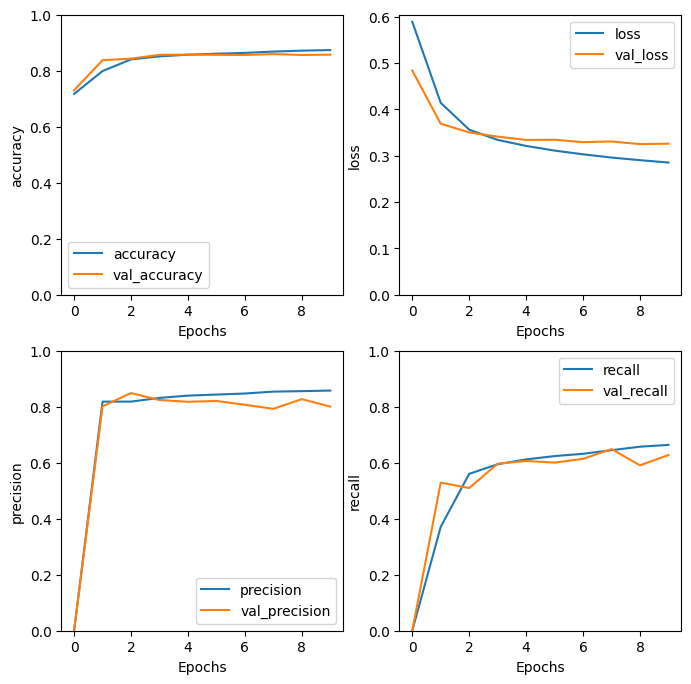

In [28]:
# Single LSTM Model

plt.figure(figsize=(8, 8))
plt.subplot(2, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(0, 1)
plt.subplot(2, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)
plt.subplot(2, 2, 3)
plot_graphs(history, 'precision')
plt.ylim(0, 1)
plt.subplot(2, 2, 4)
plot_graphs(history, 'recall')
plt.ylim(0, 1)

(0.0, 1.0)

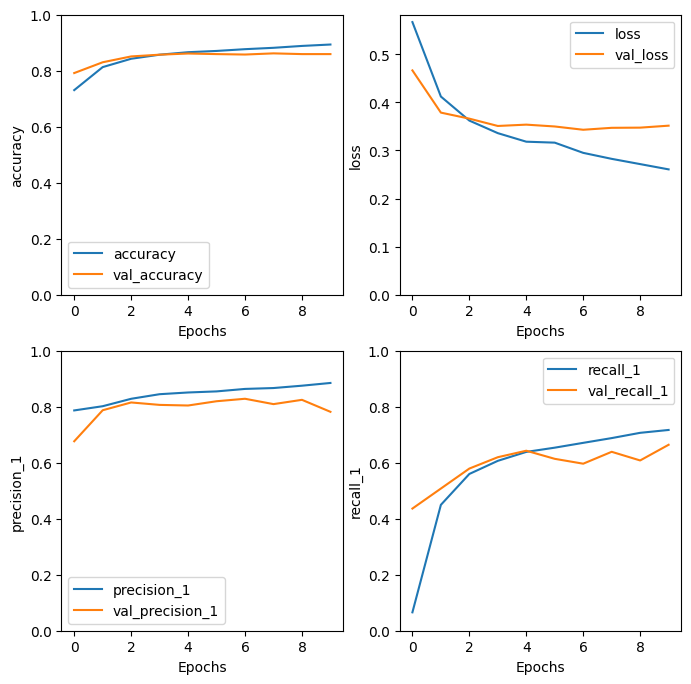

In [29]:
# Simple RNN Model

plt.figure(figsize=(8, 8))
plt.subplot(2, 2, 1)
plot_graphs(simpleRNNHistory, 'accuracy')
plt.ylim(0, 1)
plt.subplot(2, 2, 2)
plot_graphs(simpleRNNHistory, 'loss')
plt.ylim(0, None)
plt.subplot(2, 2, 3)
plot_graphs(simpleRNNHistory, 'precision_1')
plt.ylim(0, 1)
plt.subplot(2, 2, 4)
plot_graphs(simpleRNNHistory, 'recall_1')
plt.ylim(0, 1)

(0.0, 1.0)

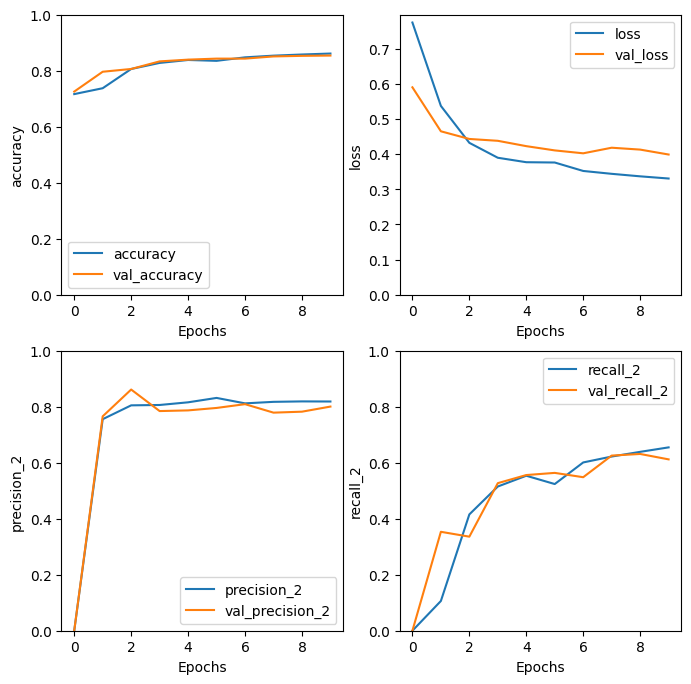

In [31]:
# Single Double LSTM Model

plt.figure(figsize=(8, 8))
plt.subplot(2, 2, 1)
plot_graphs(doubleRNNHistory, 'accuracy')
plt.ylim(0, 1)
plt.subplot(2, 2, 2)
plot_graphs(doubleRNNHistory, 'loss')
plt.ylim(0, None)
plt.subplot(2, 2, 3)
plot_graphs(doubleRNNHistory, 'precision_2')
plt.ylim(0, 1)
plt.subplot(2, 2, 4)
plot_graphs(doubleRNNHistory, 'recall_2')
plt.ylim(0, 1)